# Lion-Q-VQE
## Greatest Minimum Variance Portfolio (GMVP)

### Imports

In [16]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, EfficientSU2
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler, StatevectorEstimator

from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient, SPSAEstimatorGradient, LinCombEstimatorGradient, ParamShiftEstimatorGradient, ParamShiftSamplerGradient, QFI, DerivativeType, LinCombQGT
from qiskit_optimization.translators import from_docplex_mp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scienceplots

In [17]:
# Portfolio optimization
best_portfolio = None
best_return = -np.inf

# Lists to store results for plotting
returns_list = []
risks_list = []

# Iterate over random portfolio allocations
for _ in range(10000):  # Try 10,000 random allocations
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    scaled_weights = weights * budget # Scale weights to fit the budget

    # Calculate portfolio return and risk
    portfolio_return = np.dot(scaled_weights, ev)  # Expected return
    portfolio_risk = np.dot(scaled_weights.T, np.dot(covariance, scaled_weights))  # Variance or RISK!!
    portfolio_std_dev = np.sqrt(portfolio_risk)  # Standard deviation

    # Calculate the adjusted return based on risk (weighted by risk_factor)
    adjusted_return = portfolio_return - risk_factor * portfolio_risk

    ## Store the results for plotting
    returns_list.append(portfolio_return)
    risks_list.append(portfolio_risk)

    ## Best Portfolio Tracking
    # Select the best portfolio based on the highest expected return
    if adjusted_return > best_return:
        best_return = adjusted_return
        best_portfolio = scaled_weights
    ########################################

# Calculate expected return of the best portfolio
expected_return_best_portfolio = np.dot(best_portfolio, ev)

# Print results
print("Best Portfolio Allocation (scaled to budget):", best_portfolio)
print(f"\nExpected Return of Best Portfolio: {expected_return_best_portfolio:.4%}")
print("Risk of Best Portfolio:", np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)))

Best Portfolio Allocation (scaled to budget): [1.05662507 1.17616793 0.568453   0.49755793 1.84368244 0.06866904
 0.27639143 0.10548637 1.5354433  0.16084284 1.30164609 0.11845799
 0.8969988  1.14091477 1.7918806  1.56490347 0.2322806  0.07948151
 0.2282943  0.00414345 0.02007109 1.16811877 1.73837229 0.66507371
 1.76004323]

Expected Return of Best Portfolio: 7.3980%
Risk of Best Portfolio: 0.04305440517176642


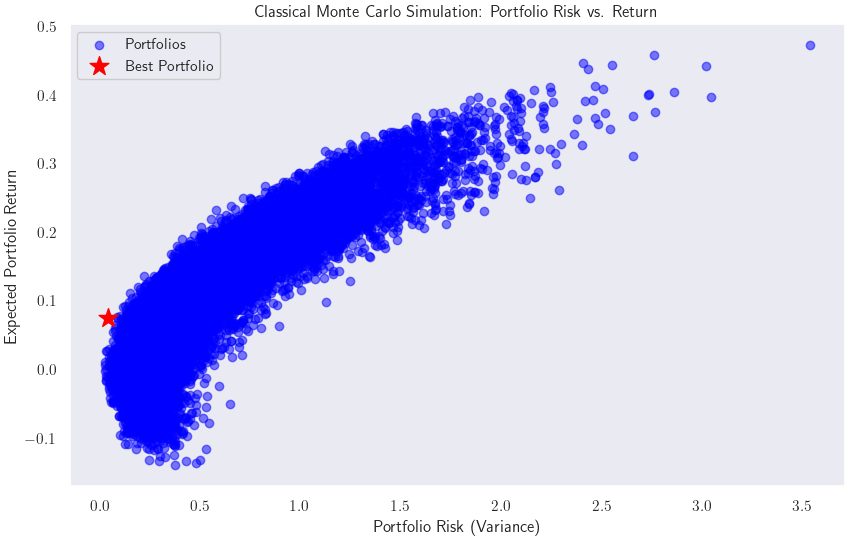

In [18]:
# Plotting the results

plt.style.use(['science', 'grid'])

sns.set()

plt.figure(figsize=(10, 6))
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Portfolios')
plt.scatter(np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)), np.dot(ev, best_portfolio), 
            color='red', marker='*', s=200, label='Best Portfolio')
plt.title('Classical Monte Carlo Simulation: Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid()
plt.show()

### Global Minimum-Variance Portfolio (GMVP)

In [19]:
from scipy.optimize import minimize



GMVP Weights (scaled to budget): [1.02652615 0.95667758 1.01374508 1.00403987 0.94206605 0.99762256
 0.01274272 1.01433397 1.07882557 0.092016   1.00421664 0.98645897
 1.03660473 0.96722464 1.00195748 1.00704283 1.03551401 0.96782747
 0.02901428 0.         0.         1.00484405 0.94075794 0.87072143
 1.00922   ]

Expected Return of GMVP: -0.0641%
Risk of GMVP: 0.00889618732228109


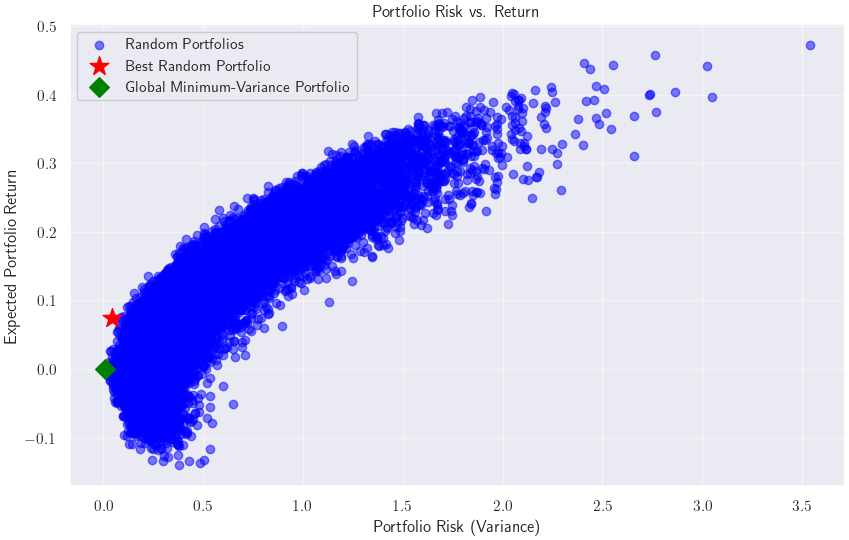

In [20]:
# -------------------------------
# Compute the Global Minimum-Variance Portfolio (GMVP)
# -------------------------------

# Define the portfolio variance function to minimize
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: Sum of weights equals 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds: Weights between 0 and 1 (long-only constraint)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: Equal weights
initial_guess = num_assets * [1.0 / num_assets]

# Optimize to find the GMVP weights
result = minimize(
    portfolio_variance,
    initial_guess,
    args=(covariance,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract the GMVP weights
gmvp_weights = result.x

# Calculate GMVP return and risk
gmvp_return = np.dot(gmvp_weights, ev) * budget  # Scale by budget
gmvp_variance = portfolio_variance(gmvp_weights * budget, covariance)  # Scale weights
gmvp_std_dev = np.sqrt(gmvp_variance)

print("\nGMVP Weights (scaled to budget):", gmvp_weights * budget)
print(f"\nExpected Return of GMVP: {gmvp_return:.4%}")
print("Risk of GMVP:", gmvp_variance)

# -------------------------------
# Plotting the results
# -------------------------------

plt.style.use(['science', 'grid'])
sns.set()

plt.figure(figsize=(10, 6))

# Scatter plot of random portfolios
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Random Portfolios')

# Plot the Best Portfolio from Random Sampling
plt.scatter(
    np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)),
    np.dot(ev, best_portfolio),
    color='red',
    marker='*',
    s=200,
    label='Best Random Portfolio'
)

# Plot the GMVP
plt.scatter(
    gmvp_variance,
    gmvp_return,
    color='green',
    marker='D',
    s=100,
    label='Global Minimum-Variance Portfolio'
)

plt.title('Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()